<a href="https://colab.research.google.com/github/Maryam1031/Violence-Detection-using-custom-3D-CNN/blob/main/3D_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import necessary libraries
import os
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv3D, MaxPooling3D, BatchNormalization, Dropout, Flatten, Dense, Concatenate, Input
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping
from tensorflow.keras.utils import to_categorical, Sequence
import glob
import matplotlib.pyplot as plt

# Ensure you have the sequence data and labels ready.
# Example structure: `sequence_data` is a numpy array of shape (num_samples, 16, 60, 90, 3)
# `sequence_labels` is an array of shape (num_samples,), where each label is either 0 or 1 for binary classification.
# These variables are assumed to be available from your data preprocessing steps.


In [ ]:
import os
import cv2
import numpy as np

def load_images_from_folders(violence_folder, nonviolence_folder, max_frames=1600, target_size=(60, 90)):
    """Load and resize images from both folders with labels, limiting number of frames per folder."""
    images = []
    labels = []  # 0 for non-violent, 1 for violent

    def load_images_from_path(folder_path, label):
        count = 0
        for video_folder in os.listdir(folder_path):
            if count >= max_frames:  # Limit frames per folder
                break
            output_path = os.path.join(folder_path, video_folder, 'output')
            if os.path.isdir(output_path):
                for filename in os.listdir(output_path):
                    img_path = os.path.join(output_path, filename)
                    img = cv2.imread(img_path)
                    if img is not None:
                        img = cv2.resize(img, target_size)  # Resize right after loading
                        images.append(img)
                        labels.append(label)
                        count += 1
                        if count >= max_frames:
                            break

    # Load frames and labels for both violence and non-violence folders
    load_images_from_path(violence_folder, label=1)
    load_images_from_path(nonviolence_folder, label=0)

    return np.array(images), np.array(labels)

# Paths for data directories
violence_directory = '/content/drive/MyDrive/of/violence_of'
nonviolence_directory = '/content/drive/MyDrive/of/nonviolence_of'

# Load and resize frames
frames, labels = load_images_from_folders(violence_directory, nonviolence_directory)

# Function to create sequences from frames
def create_sequences_with_labels(frames, labels, sequence_length=16):
    sequences, sequence_labels = [], []
    for i in range(0, len(frames) - sequence_length + 1, sequence_length):  # Step by sequence length for efficiency
        sequence = frames[i:i + sequence_length]
        sequences.append(sequence)
        sequence_labels.append(labels[i + sequence_length - 1])  # Use last frame label
    return np.array(sequences), np.array(sequence_labels)

# Define sequence length and create sequences
sequence_length = 16
sequence_data, sequence_labels = create_sequences_with_labels(frames, labels, sequence_length=sequence_length)
print(f"Created {len(sequence_data)} sequences of frames.")


Created 186 sequences of frames.


In [ ]:
# Load frames and labels
violence_directory = '/content/drive/MyDrive/of/violence_of'
nonviolence_directory = '/content/drive/MyDrive/of/nonviolence_of'
frames, labels = load_images_from_folders(violence_directory, nonviolence_directory)

# Resize all frames to (60, 90) - outside the loading function
resized_frames = [cv2.resize(frame, (60, 90)) for frame in frames]

# Convert list to numpy array
resized_frames = np.array(resized_frames)


In [ ]:
# Function to create sequences with labels
def create_sequences_with_labels(frames, labels, sequence_length=16):
    sequences, sequence_labels = [], []
    for i in range(len(frames) - sequence_length + 1):
        sequence = frames[i:i + sequence_length]
        sequences.append(sequence)
        sequence_labels.append(labels[i + sequence_length - 1])  # Use the label of the last frame in the sequence
    return np.array(sequences), np.array(sequence_labels)

# Define sequence length and create sequences
sequence_length = 16
sequence_data, sequence_labels = create_sequences_with_labels(resized_frames, labels, sequence_length=sequence_length)
print(f"Created {len(sequence_data)} sequences of frames.")


Created 2961 sequences of frames.


In [ ]:
import numpy as np
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# Assuming `sequence_data` and `sequence_labels` have already been defined

# Convert labels to categorical (one-hot encoding) for binary classification
sequence_labels_one_hot = to_categorical(sequence_labels, num_classes=2)

# Split the data into training and validation sets
sequence_data_train, sequence_data_val, sequence_labels_train, sequence_labels_val = train_test_split(
    sequence_data, sequence_labels_one_hot, test_size=0.2, random_state=42
)


In [ ]:
class DataGenerator(Sequence):
    def __init__(self, data, labels, batch_size=32, dim=(16, 60, 90, 3), shuffle=True):
        self.data = data
        self.labels = labels
        self.batch_size = batch_size
        self.dim = dim
        self.shuffle = shuffle
        self.indices = np.arange(len(self.data))
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.data) / self.batch_size))

    def __getitem__(self, index):
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        # Transpose the dimensions of the data to match the expected shape (16, 60, 90, 3)
        X = np.array([np.transpose(self.data[i], (0, 2, 1, 3)) for i in batch_indices])
        y = np.array([self.labels[i] for i in batch_indices])
        return X, y

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

# Initialize the data generators
train_generator = DataGenerator(sequence_data_train, sequence_labels_train, batch_size=16)
val_generator = DataGenerator(sequence_data_val, sequence_labels_val, batch_size=16)

In [ ]:
def create_custom_3d_cnn_with_attention(input_shape):
    from tensorflow.keras.layers import Input, Conv3D, MaxPooling3D, BatchNormalization, Dropout, Dense, Concatenate, GlobalAveragePooling3D
    from tensorflow.keras.models import Model
    from tensorflow.keras.regularizers import l2

    input_layer = Input(shape=input_shape)

    # First convolutional block
    x = Conv3D(16, kernel_size=(3, 3, 3), activation='relu', kernel_regularizer=l2(0.001))(input_layer)
    x = MaxPooling3D(pool_size=(2, 2, 2))(x)
    x = BatchNormalization(momentum=0.99)(x)

    # Spatial Attention Module
    spatial_attention_avg = Conv3D(16, kernel_size=(1, 1, 1), activation='sigmoid')(x)
    spatial_attention_max = Conv3D(16, kernel_size=(1, 1, 1), activation='sigmoid')(x)
    spatial_attention = Concatenate()([spatial_attention_avg, spatial_attention_max])
    spatial_attention = Conv3D(16, kernel_size=(1, 1, 1), activation='sigmoid')(spatial_attention)
    x = x * spatial_attention  # Apply attention

    # Second convolutional block
    x = Conv3D(32, kernel_size=(3, 3, 3), activation='relu', kernel_regularizer=l2(0.001))(x)
    x = MaxPooling3D(pool_size=(2, 2, 2))(x)
    x = BatchNormalization(momentum=0.99)(x)

    # Global Average Pooling
    x = GlobalAveragePooling3D()(x)

    # Fully Connected Layers
    x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = Dropout(0.1)(x)
    x = Dense(64, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = Dropout(0.1)(x)

    # Output layer for binary classification
    output_layer = Dense(2, activation='softmax')(x)

    # Create and return the model
    model = Model(inputs=input_layer, outputs=output_layer)
    return model


# Define input shape (unchanged)
input_shape = (16, 60, 90, 3)

# Create the model
cnn_model_with_attention = create_custom_3d_cnn_with_attention(input_shape)

# Compile the model with gradient clipping and reduced learning rate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

optimizer = Adam(learning_rate=0.0001, clipvalue=1.0)  # Gradient clipping added
cnn_model_with_attention.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Learning rate scheduler callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# Display the model summary
cnn_model_with_attention.summary()



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 16, 60, 90, 3)  │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d (Conv3D)           │ (None, 14, 58, 88, 16) │          1,312 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling3d             │ (None, 7, 29, 44, 16)  │              0 │ conv3d[0][0]           │
│ (MaxPooling3D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 7, 29, 44, 16)  │             64 │ max_pooling3d[0][0]    │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_1 (Conv3D)         │ (None, 7, 29, 44, 16)  │            272 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_2 (Conv3D)         │ (None, 7, 29, 44, 16)  │            272 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 7, 29, 44, 32)  │              0 │ conv3d_1[0][0],        │
│                           │                        │                │ conv3d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_3 (Conv3D)         │ (None, 7, 29, 44, 16)  │            528 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply (Multiply)       │ (None, 7, 29, 44, 16)  │              0 │ batch_normalization[0… │
│                           │                        │                │ conv3d_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_4 (Conv3D)         │ (None, 5, 27, 42, 32)  │         13,856 │ multiply[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling3d_1           │ (None, 2, 13, 21, 32)  │              0 │ conv3d_4[0][0]         │
│ (MaxPooling3D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 2, 13, 21, 32)  │            128 │ max_pooling3d_1[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling3d  │ (None, 32)             │              0 │ batch_normalization_1… │
│ (GlobalAveragePooling3D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 128)            │          4,224 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 128)            │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 64)             │          8,256 │ dropout[0][0]          │
├──────────────────────

 Total params: 29,042 (113.45 KB)

 Trainable params: 28,946 (113.07 KB)

 Non-trainable params: 96 (384.00 B)

In [ ]:
import os
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger

# Set up directories for checkpoints and logs
checkpoint_dir = '/content/checkpoints'
csv_log_dir = '/content/logs'
os.makedirs(checkpoint_dir, exist_ok=True)
os.makedirs(csv_log_dir, exist_ok=True)

# Define callbacks
checkpoint_callback = ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir, 'model3_epoch_{epoch:02d}.weights.h5'), # Changed the file extension to .weights.h5
    save_weights_only=True,
    save_best_only=False,
    verbose=1
)
csv_logger = CSVLogger(os.path.join(csv_log_dir, 'training3_log.csv'), append=True)

# Pass only `checkpoint_callback` and `csv_logger` to the model's `fit()` function
callbacks = [checkpoint_callback, csv_logger]

In [ ]:
import os
import glob # Import the glob module

from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger

# Check if there are any checkpoints to resume training
checkpoint_files = glob.glob(os.path.join(checkpoint_dir, 'model3_epoch_*.h5'))
if checkpoint_files:
    last_checkpoint = max(checkpoint_files, key=os.path.getctime)
    print(f"Resuming training from {last_checkpoint}")
    cnn_model_with_attention.load_weights(last_checkpoint)

In [ ]:
# Train the model using the data generators
history = cnn_model_with_attention.fit(
    train_generator,
    validation_data=val_generator,
    epochs=40,
    callbacks=[checkpoint_callback, csv_logger]
)

Epoch 1/40
147/148 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6355 - loss: 0.7893
Epoch 1: saving model to /content/checkpoints/model3_epoch_01.weights.h5
148/148 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.6364 - loss: 0.7885 - val_accuracy: 0.7365 - val_loss: 0.7193
Epoch 2/40
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8117 - loss: 0.5987
Epoch 2: saving model to /content/checkpoints/model3_epoch_02.weights.h5
148/148 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.8116 - loss: 0.5986 - val_accuracy: 0.6723 - val_loss: 0.7860
Epoch 3/40
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8242 - loss: 0.5572
Epoch 3: saving model to /content/checkpoints/model3_epoch_03.weights.h5
148/148 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.8242 - loss: 0.5571 - val_accuracy: 0.8057 - val_loss: 0.6059
Epoch 4/40
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8519 - loss: 0.5120
Epoch 4: saving model to /content/checkpoints/model3_epoch_04.weights.h5
148/14

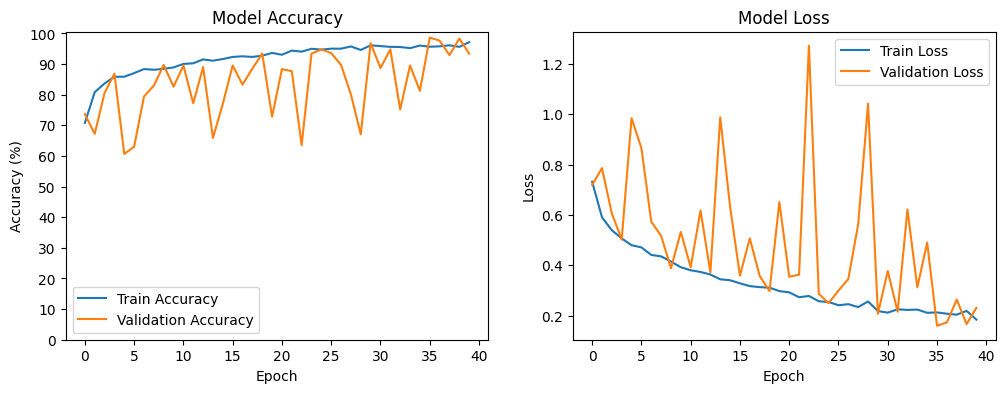

In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy and loss
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot([x * 100 for x in history.history['accuracy']], label='Train Accuracy')  # Multiply by 100 to display percentage
plt.plot([x * 100 for x in history.history['val_accuracy']], label='Validation Accuracy')  # Multiply by 100
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')  # Label as percentage
plt.legend()

# Adjust the y-ticks for accuracy (from 10 to 100)
plt.yticks(range(0, 110, 10))  # Set ticks from 0 to 100 with steps of 10

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [ ]:
# Train the model using the data generators
history = cnn_model_with_attention.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    callbacks=[checkpoint_callback, csv_logger]
)

Epoch 1/30
147/148 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9651 - loss: 0.2011
Epoch 1: saving model to /content/checkpoints/model3_epoch_01.weights.h5
148/148 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.9651 - loss: 0.2010 - val_accuracy: 0.9595 - val_loss: 0.2250
Epoch 2/30
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9724 - loss: 0.1828
Epoch 2: saving model to /content/checkpoints/model3_epoch_02.weights.h5
148/148 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.9723 - loss: 0.1829 - val_accuracy: 0.6959 - val_loss: 0.8671
Epoch 3/30
147/148 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9716 - loss: 0.1770
Epoch 3: saving model to /content/checkpoints/model3_epoch_03.weights.h5
148/148 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - accuracy: 0.9715 - loss: 0.1770 - val_accuracy: 0.9916 - val_loss: 0.1472
Epoch 4/30
147/148 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9841 - loss: 0.1577
Epoch 4: saving model to /content/checkpoints/model3_epoch_04.weights.h5
148/14

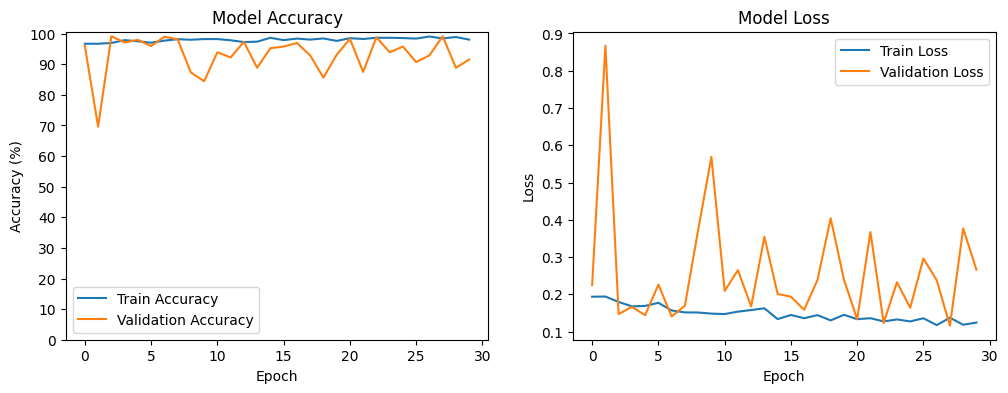

In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy and loss
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot([x * 100 for x in history.history['accuracy']], label='Train Accuracy')  # Multiply by 100 to display percentage
plt.plot([x * 100 for x in history.history['val_accuracy']], label='Validation Accuracy')  # Multiply by 100
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')  # Label as percentage
plt.legend()

# Adjust the y-ticks for accuracy (from 10 to 100)
plt.yticks(range(0, 110, 10))  # Set ticks from 0 to 100 with steps of 10

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [ ]:
# Save the entire model after training
cnn_model_with_attention.save('/content/my_model.keras')
